<font size=10><b>Сегментация изображений<b></font>
---

In [3]:
!chcp 65001

Active code page: 65001


In [4]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isnt guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

'ln' is not recognized as an internal or external command,
operable program or batch file.


Gen RAM Free: 11.5 GB  | Proc size: 67.4 MB
GPU RAM Free: 5399MB | Used: 652MB | Util  11% | Total 6144MB


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15, 4)

<font size=5>Цель проекта решить задачу <i>сегментации медицинских снимков</i>.<br>
<font>

В конце проекта подготовим отчет по работе, чтобы быстро отслеживать результаты. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:
* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?

---

Датасет [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html). состоит из фотографий двух типов **поражений кожи:** меланома и родинки.<br>
<table><tr><td>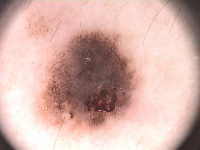</td><td>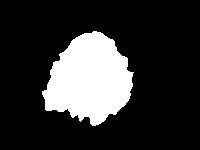</td></tr></table>

<font size=10>Эпизод 1</font>


---


<font size=6>Загрузка данных</font>

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...


* `X.bmp` — изображение, которое нужно сегментировать, <br>
* `X_lesion.bmp` — результат сегментации.

In [2]:
import os
from skimage.io import imread


images = []
lesions = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
  if root.endswith('_Dermoscopic_Image'):
    images.append(imread(os.path.join(root, files[0])))
  if root.endswith('_lesion'):
    lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на  256×256  пикселей. Для изменения размера изображений можно использовать skimage.transform.resize(). Эта функция также автоматически нормализует изображения в диапазоне  [0,1] .

In [3]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [4]:
import numpy as np


X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


### Посмотрим на данные 

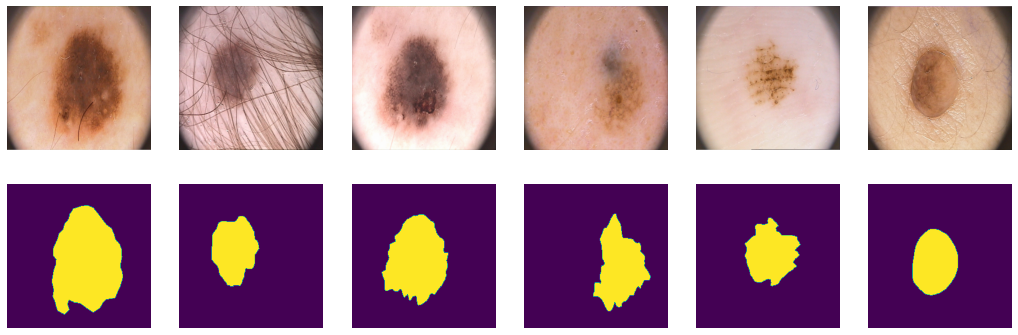

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


plt.figure(figsize=(18, 6))
for i in range(6):
  plt.subplot(2, 6, i+1)
  plt.axis('off')
  plt.imshow(X[i])

  plt.subplot(2, 6, i+7)
  plt.axis('off')
  plt.imshow(Y[i])
plt.show()

Разделим наши 200 картинок на 100/50/50 для обучения, валидации и теста соответственно

In [10]:
ix = np.random.choice(len(X), len(X), replace=False)
tr, val, ts = np.split(ix, [100, 150])

In [11]:
print(len(tr), len(val), len(ts))

100 50 50


In [12]:
Y_ = torch.from_numpy(Y)
Y_ = np.rollaxis(Y_.unsqueeze_(0).repeat(3, 1, 1, 1).numpy(), 0, 4) # Из 1-канального массива в 3х канальный
Y_label = Y_

In [13]:
X.shape, Y_label.shape

((200, 256, 256, 3), (200, 256, 256, 3))

In [14]:
train = list(zip(np.rollaxis(X[tr], 3, 1), np.rollaxis(Y_label[tr], 3, 1))) # 100 в train
val = list(zip(np.rollaxis(X[val], 3, 1), np.rollaxis(Y_label[val], 3, 1))) # 50 в val
test = list(zip(np.rollaxis(X[ts], 3, 1), np.rollaxis(Y_label[ts], 3, 1))) # 50 в test

#### PyTorch DataLoader загружаем данные

In [15]:
from torch.utils.data import DataLoader


batch_size = 6
data_train = DataLoader(train, batch_size=batch_size, shuffle=True)
data_val = DataLoader(val, batch_size=batch_size, shuffle=True)
data_test = DataLoader(test, batch_size=batch_size, shuffle=True)

**Подключение GPU**

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


<font size=10>Эпизод 2</font>


---


<font size=6>Реализация архитектуры</font>

**SegNet**

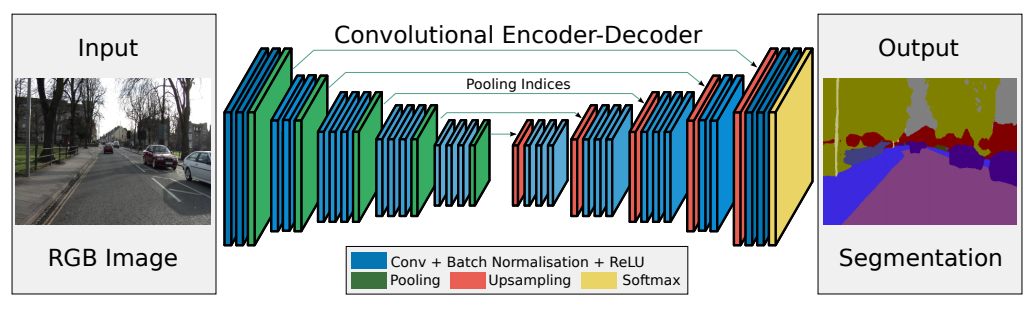

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [17]:
class SegNet(nn.Module):
  def __init__(self):
    super().__init__()

    batchNorm_momentum = 0.1

    # Encoder (downsampling)
    self.enc_conv0 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=64, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=64, momentum=batchNorm_momentum),
        nn.ReLU(),
    )

    self.enc_conv1 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=128, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=128, momentum=batchNorm_momentum),
        nn.ReLU()
    )
    
    self.enc_conv2 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=256, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=256, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=256, momentum=batchNorm_momentum),
        nn.ReLU(),
    )

    self.enc_conv3 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=512, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=512, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=512, momentum=batchNorm_momentum),
        nn.ReLU(),
    )

    self.enc_conv4 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=512, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=512, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=512, momentum=batchNorm_momentum),
        nn.ReLU(),
    )

    # Decoder (upsampling) 
    self.dec_conv4 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=512, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=512, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=512, momentum=batchNorm_momentum),
        nn.ReLU(),
    )

    self.dec_conv3 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=512, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=512, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=256, momentum=batchNorm_momentum),
        nn.ReLU(),
    )

    self.dec_conv2 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=256, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=256, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=128, momentum=batchNorm_momentum),
        nn.ReLU(),
    )

    self.dec_conv1 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=128, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=64, momentum=batchNorm_momentum),
        nn.ReLU()
    )

    self.dec_conv0 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1),
        nn.BatchNorm2d(num_features=64, momentum=batchNorm_momentum),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=3, kernel_size=(3, 3), padding=1),
    )


  def forward(self, x):
    # Encoder
    # Stage 0
    x = self.enc_conv0(x)
    x0p, id0 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)

    # Stage 1
    x = self.enc_conv1(x0p)
    x1p, id1 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)

    # Stage 2
    x = self.enc_conv2(x1p)
    x2p, id2 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)

    # Stage 3
    x = self.enc_conv3(x2p)
    x3p, id3 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True)

    # Stage 4
    x = self.enc_conv4(x3p)
    x4p, id4 = F.max_pool2d(x, kernel_size=2, stride=2, return_indices=True) 

    # Decoder
    # Stage 4
    x = F.max_unpool2d(x4p, id4, kernel_size=2, stride=2)
    x = self.dec_conv4(x)

    # Stage 3
    x = F.max_unpool2d(x, id3, kernel_size=2, stride=2)
    x = self.dec_conv3(x)

    # Stage 2
    x = F.max_unpool2d(x, id2, kernel_size=2, stride=2)
    x = self.dec_conv2(x)

    # Stage 1
    x = F.max_unpool2d(x, id1, kernel_size=2, stride=2)
    x = self.dec_conv1(x)

    # Stage 0
    x = F.max_unpool2d(x, id0, kernel_size=2, stride=2)
    x = self.dec_conv0(x)

    return x

## Метрика

$IoU=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [18]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
  outputs = outputs.squeeze(1).byte()
  labels = labels.squeeze(1).byte()
  SMOOTH = 1e-8
  intersection_test = (outputs & labels).float().sum()
  intersection = (outputs & labels).float().sum((1, 2)) # Will be zero if Truth=0 or Prediction=0
  union = (outputs | labels).float().sum((1, 2))        # Will be zero if both are 0

  iou = (intersection + SMOOTH) / (union + SMOOTH) # We smooth our devision to avoid 0/0

  thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10

  return iou

In [30]:
def count_accuracy(predict, label):
    intersection = predict.byte() - label.byte()
    zero = torch.zeros_like(intersection)
    num_intersection = (intersection == zero).sum()
    num_pixels = label.numpy().size
    accuracy = num_intersection / num_pixels
    return accuracy

## Функция потерь

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

## Обучение

In [41]:
from tqdm.notebook import tqdm


def train(model, opt, loss_fn, epochs, data_tr, data_val):
  history = []
  X_val, Y_val = next(iter(data_val))
    
  for epoch in tqdm(range(epochs), desc='epoch:', unit='epoch'):
    print(f'Epoch {epoch+1}/{epochs}:')
    
    # train фаза:
    avg_train_loss = 0
    train_loss = 0
    running_loss = 0
    running_corrects = 0
    processed_data = 0
    
    model.train() # train mode
    for X_batch, Y_batch in tqdm(data_tr, desc='train:', unit='batch'):
      X_batch = X_batch.to(device)
      Y_batch = Y_batch.to(device)
      opt.zero_grad() # обнуление градиентов
        
      Y_pred = model(X_batch) # model predict
      loss = loss_fn(Y_pred, Y_batch) # count loss
      loss.backward() # backpropagation

      opt.step() # upgrade loss
    
      # записываем данные об обучении в одной эпохе
      train_loss += loss.item()
      running_loss += loss.item() * X_batch.size(0)
      # running_corrects += torch.sum(Y_pred == Y_batch.data)
      #processed_data += X_batch.size(0)

    # calculate loss to show the user
    avg_train_loss += running_loss / len(data_tr)
    # train_loss = running_loss / processed_data
    # train_acc = running_corrects.cpu().numpy() / processed_data
    
    # val фаза:
    val_loss = 0
    avg_val_loss = 0
    running_loss = 0
    running_corrects = 0
    processed_data = 0

    model.eval()
    pred_list = []
    label_list = []
    true_list = []
    for X_batch, Y_batch in tqdm(data_val, desc='val', unit='batch'):
      X_batch = X_batch.to(device)
      Y_batch = Y_batch.to(device)

      with torch.no_grad(): # отключение вычисления градиента
        Y_pred = model(X_batch) # model predict
        loss = loss_fn(Y_pred, Y_batch) # count loss
        
        # print(count_accuracy(Y_pred, Y_batch))
        
        pred_list.append(Y_pred)
        label_list.append(Y_batch)
        true_list.append(X_batch)
        
      # записываем данные об val проверке в одной эпохе
      val_loss += loss.item()
      running_loss += loss.item() * X_batch.size(0)
      # running_corrects += torch.sum(Y_pred == Y_batch.data)
      # processed_data += X_batch.size(0) 
    
    # calculate loss to show the user
    avg_val_loss += running_loss / len(data_val)
    #val_loss = running_loss/processed_data
    #val_acc = running_corrects.cpu().numpy() / processed_data   
    history.append((train_loss, val_loss, avg_train_loss, avg_val_loss)) # записываем данные в список, чтобы построить график
        
    # Visualize tools
    for k in range(6):
      plt.subplot(3, 6, k+1)
      plt.imshow(np.rollaxis(pred_list[k][k].numpy(), 0, 3))
      plt.title('Pred')
      plt.axis('off')

      plt.subplot(3, 6, k+7)
      plt.imshow(np.rollaxis(true_list[k][k].numpy(), 0, 3))
      plt.title('label')
      plt.axis('off')
        
      plt.subplot(3, 6, k+13)
      plt.imshow(np.rollaxis(label_list[k][k].numpy(), 0, 3))
      plt.title('true segmentation')
      plt.axis('off')
    plt.show()
    
    # Вывод информации на экран
    print(f'Epoch {epoch+1}/{epochs} \n val loss: {val_loss} | train loss: {train_loss}')
    print(f'Avg train loss: {avg_val_loss} | Avg val loss: {avg_train_loss}')
    
  return history

In [42]:
model = SegNet().to(device)

epoch::   0%|          | 0/30 [00:00<?, ?epoch/s]

Epoch 1/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


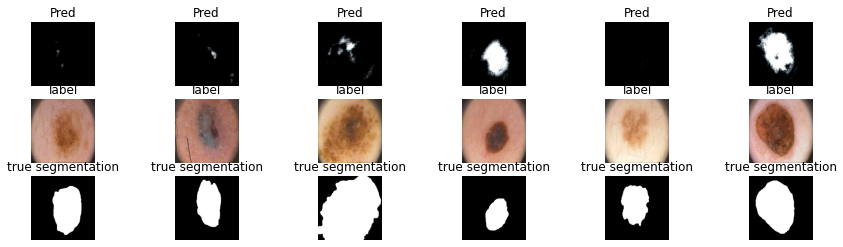

Epoch 1/30 
 val loss: 4.481657564640045 | train loss: 8.358646661043167
Avg train loss: 2.77984176741706 | Avg val loss: 2.903961150085225
Epoch 2/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


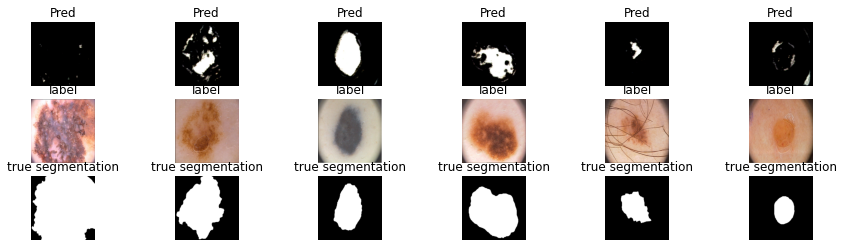

Epoch 2/30 
 val loss: 3.6094002723693848 | train loss: 5.016878247261047
Avg train loss: 2.2762166923946805 | Avg val loss: 1.7457391654743868
Epoch 3/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


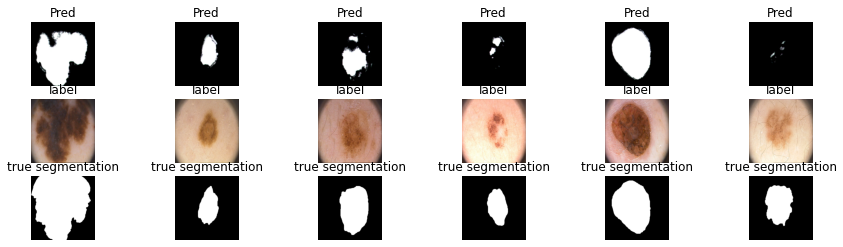

Epoch 3/30 
 val loss: 2.3450593799352646 | train loss: 5.14628392457962
Avg train loss: 1.4717276725504134 | Avg val loss: 1.7297654151916504
Epoch 4/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


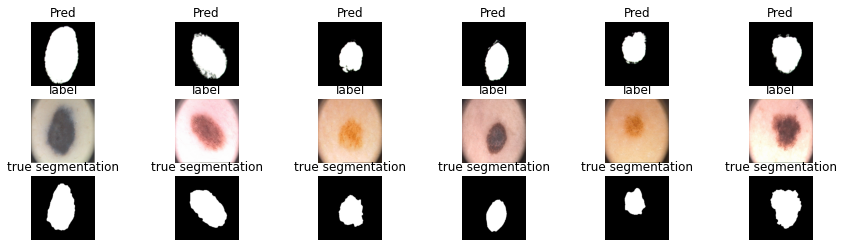

Epoch 4/30 
 val loss: 2.9447426944971085 | train loss: 4.245985209941864
Avg train loss: 1.9187484946515825 | Avg val loss: 1.4712410937337315
Epoch 5/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


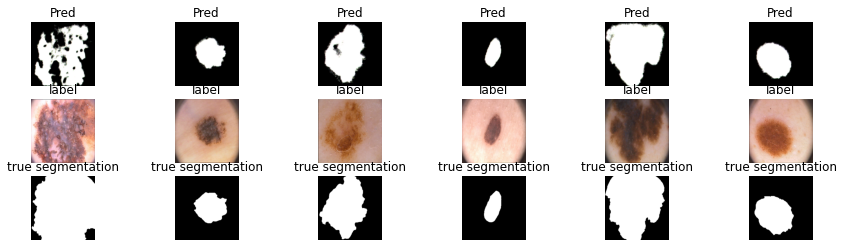

Epoch 5/30 
 val loss: 1.6985050737857819 | train loss: 4.581049025058746
Avg train loss: 1.0423948698573642 | Avg val loss: 1.588301404434092
Epoch 6/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


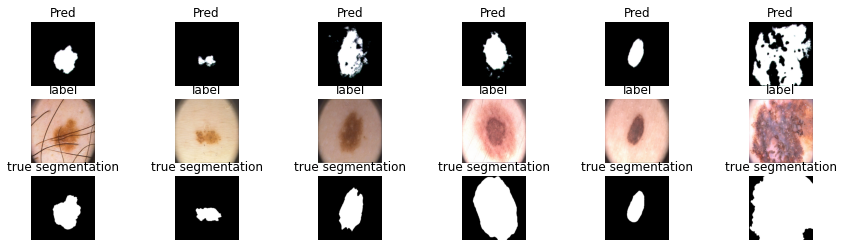

Epoch 6/30 
 val loss: 1.8898653090000153 | train loss: 4.706198051571846
Avg train loss: 1.2146509687105815 | Avg val loss: 1.634278085301904
Epoch 7/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


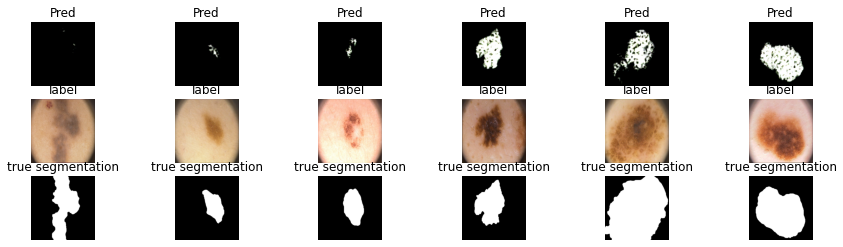

Epoch 7/30 
 val loss: 3.1909269839525223 | train loss: 4.531264781951904
Avg train loss: 1.9531268775463104 | Avg val loss: 1.5819636933943804
Epoch 8/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


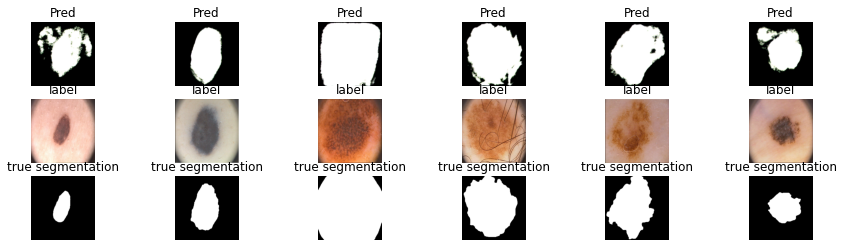

Epoch 8/30 
 val loss: 3.6502237617969513 | train loss: 4.849329128861427
Avg train loss: 2.2585784925354853 | Avg val loss: 1.682537720483892
Epoch 9/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


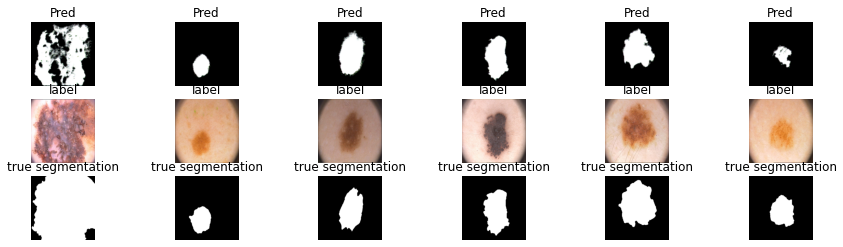

Epoch 9/30 
 val loss: 1.6907460689544678 | train loss: 4.692741364240646
Avg train loss: 1.0581188665495977 | Avg val loss: 1.6079868358724259
Epoch 10/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


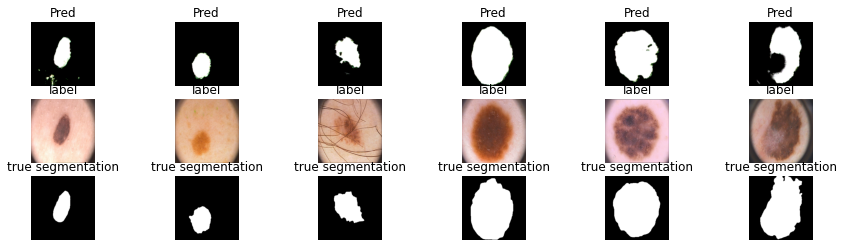

Epoch 10/30 
 val loss: 1.931280329823494 | train loss: 4.263016849756241
Avg train loss: 1.2278845608234406 | Avg val loss: 1.4839419108979843
Epoch 11/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


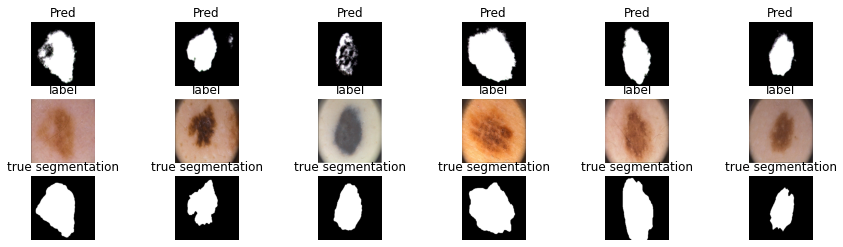

Epoch 11/30 
 val loss: 1.6954638808965683 | train loss: 4.9335871040821075
Avg train loss: 1.091260701417923 | Avg val loss: 1.6688309031374313
Epoch 12/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


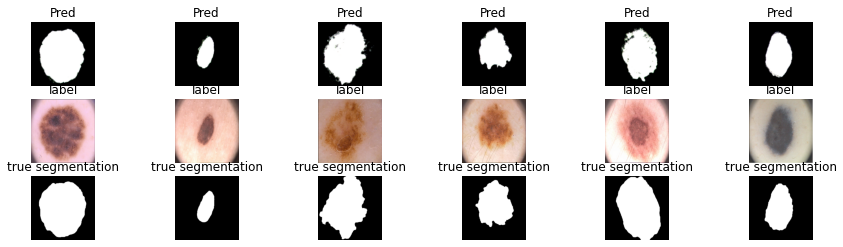

Epoch 12/30 
 val loss: 1.7780545353889465 | train loss: 4.15454688668251
Avg train loss: 1.1083471841282315 | Avg val loss: 1.4183690127204447
Epoch 13/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


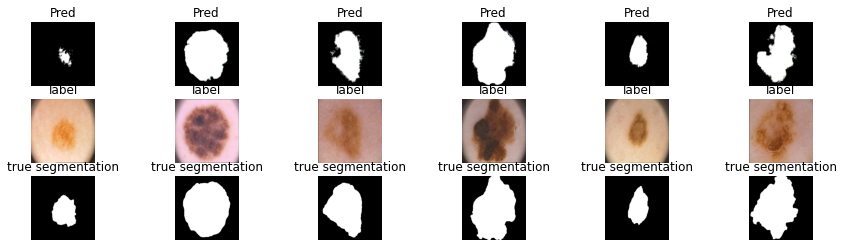

Epoch 13/30 
 val loss: 1.53160360455513 | train loss: 4.176718279719353
Avg train loss: 0.9843227201037936 | Avg val loss: 1.4148669821374558
Epoch 14/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


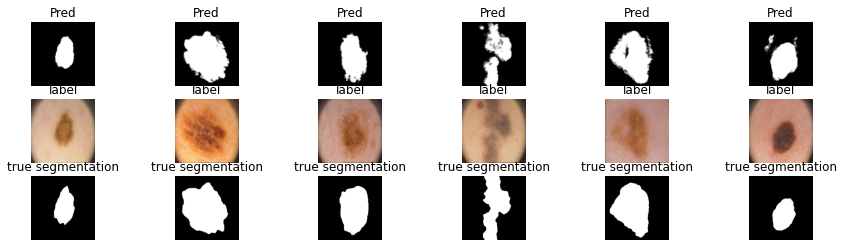

Epoch 14/30 
 val loss: 1.5541063994169235 | train loss: 3.983079381287098
Avg train loss: 0.9533750580416785 | Avg val loss: 1.3568705171346664
Epoch 15/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


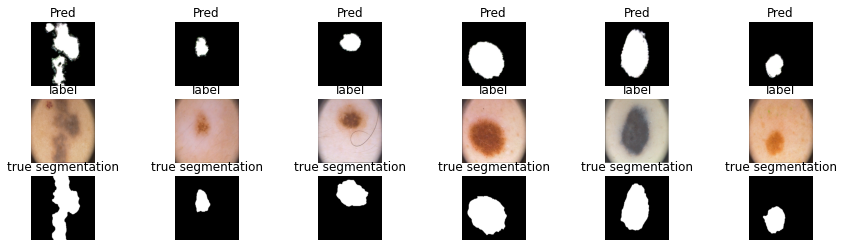

Epoch 15/30 
 val loss: 1.8069050461053848 | train loss: 3.838416874408722
Avg train loss: 1.1386265854040782 | Avg val loss: 1.333873186041327
Epoch 16/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


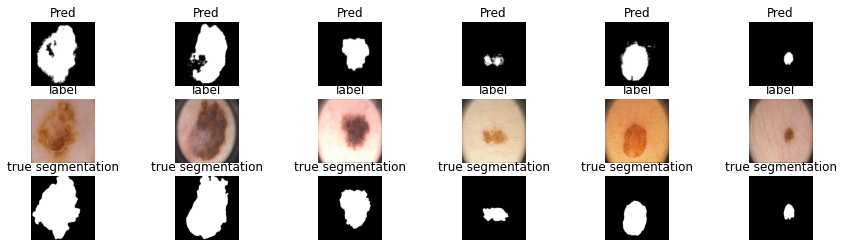

Epoch 16/30 
 val loss: 1.381720446050167 | train loss: 4.049829974770546
Avg train loss: 0.8917658842272229 | Avg val loss: 1.3873419989557827
Epoch 17/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


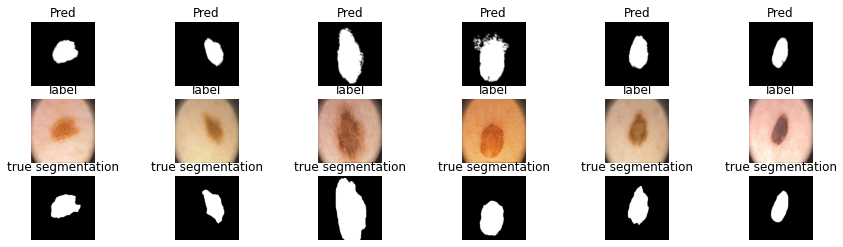

Epoch 17/30 
 val loss: 1.5617425441741943 | train loss: 3.9561480283737183
Avg train loss: 0.9663954046037462 | Avg val loss: 1.3536633708897758
Epoch 18/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


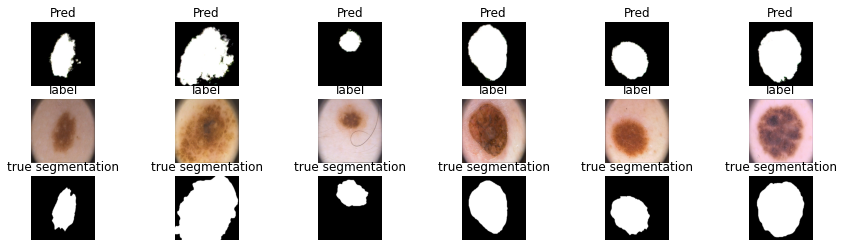

Epoch 18/30 
 val loss: 1.8067497238516808 | train loss: 4.417399927973747
Avg train loss: 1.1601507912079494 | Avg val loss: 1.4836656994679396
Epoch 19/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


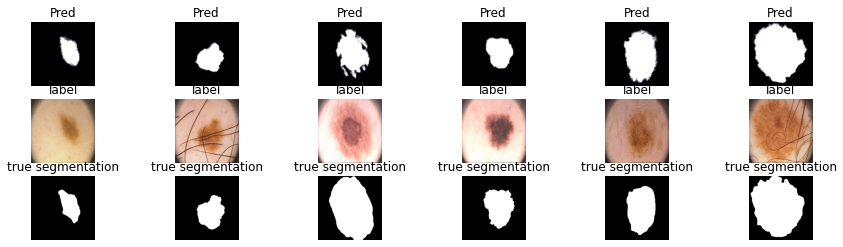

Epoch 19/30 
 val loss: 1.7249552235007286 | train loss: 4.535705998539925
Avg train loss: 1.1147802455557718 | Avg val loss: 1.585589349269867
Epoch 20/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


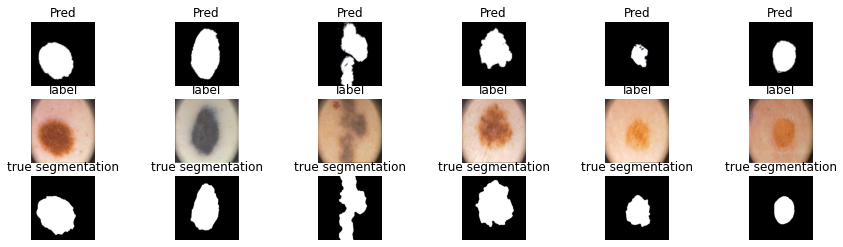

Epoch 20/30 
 val loss: 1.636821486055851 | train loss: 4.400027498602867
Avg train loss: 1.0338299125432968 | Avg val loss: 1.5350626742138582
Epoch 21/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


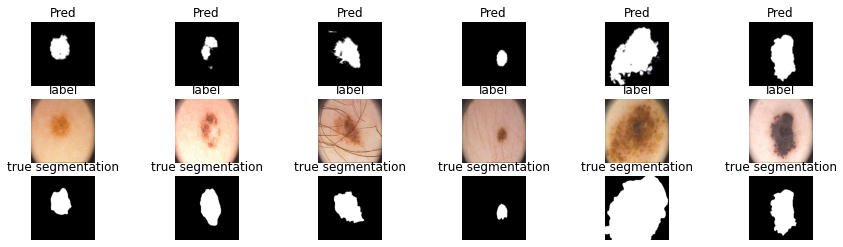

Epoch 21/30 
 val loss: 1.797337844967842 | train loss: 4.20198729634285
Avg train loss: 1.0537280473444197 | Avg val loss: 1.465729915043887
Epoch 22/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


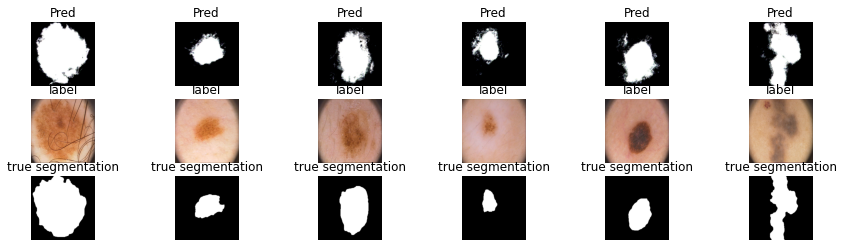

Epoch 22/30 
 val loss: 2.367438867688179 | train loss: 4.014357775449753
Avg train loss: 1.5097494423389435 | Avg val loss: 1.3990358990781449
Epoch 23/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


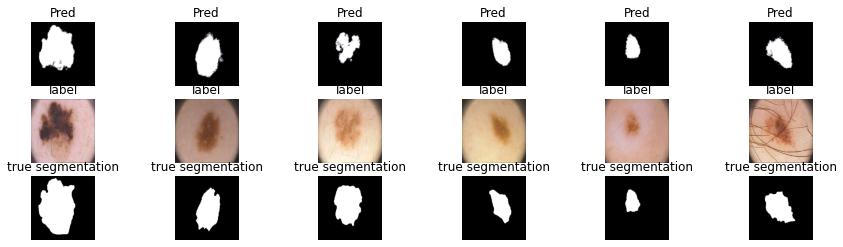

Epoch 23/30 
 val loss: 1.617186464369297 | train loss: 3.8505177050828934
Avg train loss: 1.0244293096992705 | Avg val loss: 1.3348973814178915
Epoch 24/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


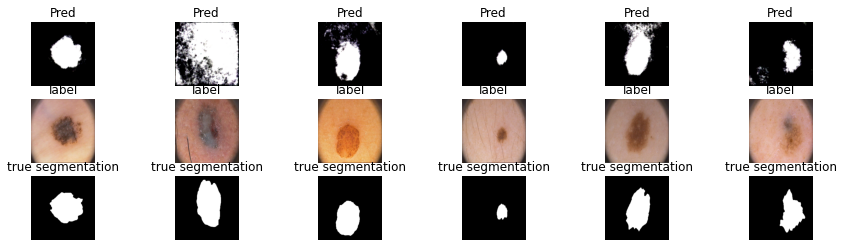

Epoch 24/30 
 val loss: 2.2403694540262222 | train loss: 3.8619032502174377
Avg train loss: 1.369014670451482 | Avg val loss: 1.3271235157461727
Epoch 25/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


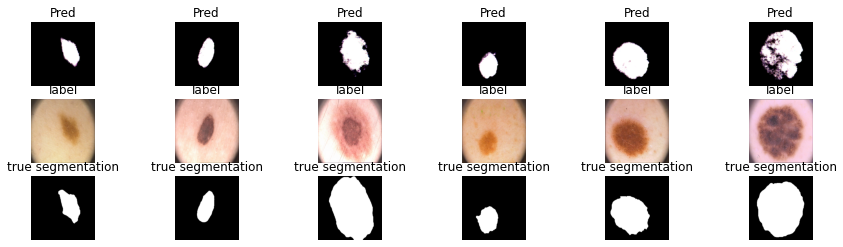

Epoch 25/30 
 val loss: 2.6075484603643417 | train loss: 5.313587874174118
Avg train loss: 1.4584316843085818 | Avg val loss: 1.8410064963733448
Epoch 26/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


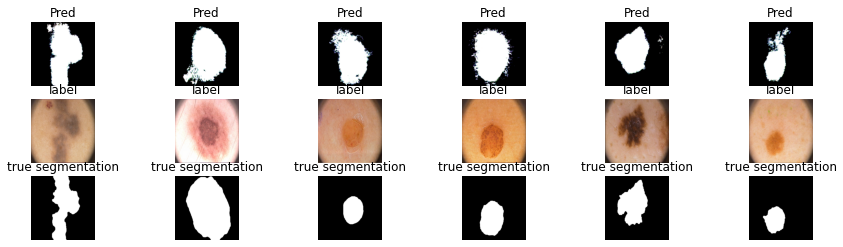

Epoch 26/30 
 val loss: 2.1760791689157486 | train loss: 4.318111300468445
Avg train loss: 1.3678208622667525 | Avg val loss: 1.4826207476503708
Epoch 27/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


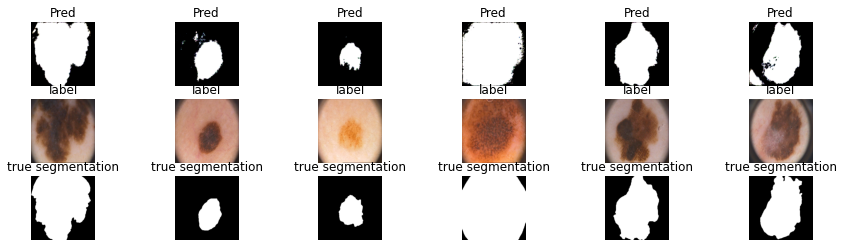

Epoch 27/30 
 val loss: 1.776779718697071 | train loss: 4.057174265384674
Avg train loss: 1.101769776807891 | Avg val loss: 1.3924117123379427
Epoch 28/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


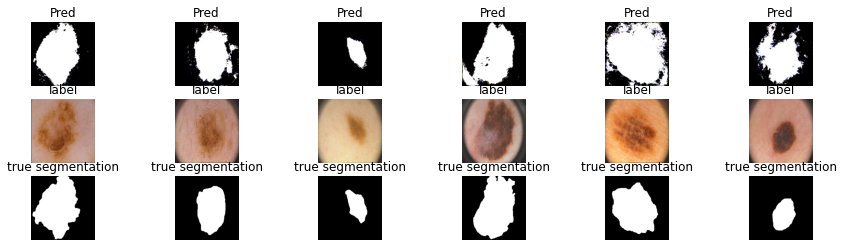

Epoch 28/30 
 val loss: 2.4627932384610176 | train loss: 4.382588900625706
Avg train loss: 1.5923950158887439 | Avg val loss: 1.5334256151143242
Epoch 29/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


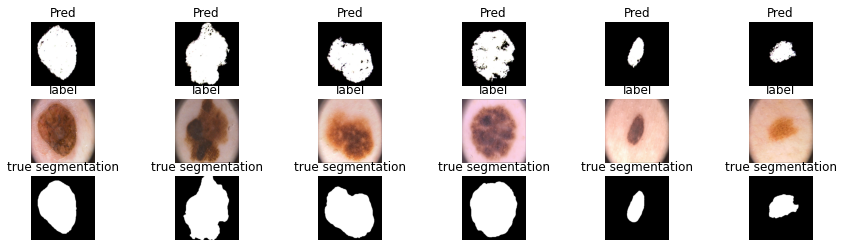

Epoch 29/30 
 val loss: 1.869969055056572 | train loss: 4.4813199788331985
Avg train loss: 1.19504604405827 | Avg val loss: 1.5365306226646198
Epoch 30/30:


train::   0%|          | 0/17 [00:00<?, ?batch/s]

val:   0%|          | 0/9 [00:00<?, ?batch/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


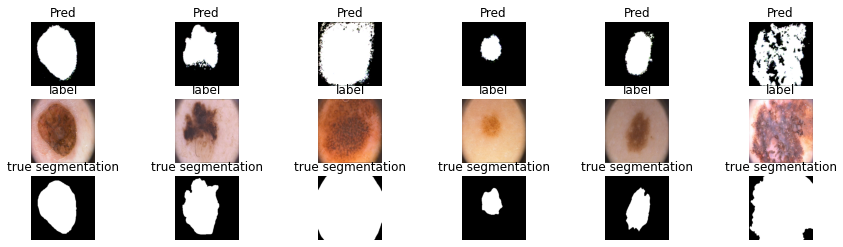

Epoch 30/30 
 val loss: 1.896191731095314 | train loss: 4.68775001168251
Avg train loss: 1.1418294608592987 | Avg val loss: 1.6321771688321058
Wall time: 1h 59min 50s


In [44]:
%%time
max_epochs = 30
pos_weight = torch.ones([256])
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
# criterion = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
history = train(model, optim, criterion, max_epochs, data_train, data_val)

In [49]:
train_loss, val_loss, avg_train_loss, avg_val_loss = zip(*history)

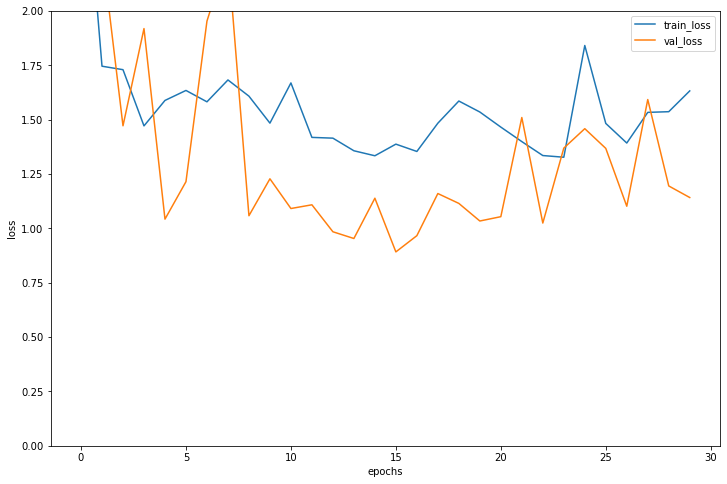

In [50]:
plt.figure(figsize=(12, 8))
plt.plot(avg_train_loss, label='train_loss')
plt.plot(avg_val_loss, label='val_loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim([0, 2])
plt.show()

## Функционал для предсказания фотографий пользователя

In [51]:
def get_images(folder: str) -> list[np.ndarray]:
    """ Функция загружает изображения в numpy массив 
        и сохраняет каждое в список
        folder: путь к директории """
    images = []
    for files in os.listdir(folder):
        if files.endswith('.jpg'):
            images.append(imread(os.path.join(folder, files)))
    return images

In [52]:
def get_resize_images(images: list[np.ndarray], size=(256, 256)) -> list[np.ndarray]:
    """ Функция для изменения размера изображения 
        image: изображение в numpy массиве
        size: изменение изображения, по умолчанию 256x256 """
    X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
    X = [np.rollaxis(x, 2, 0) for x in X]
    return X

In [53]:
def predict(model, folder='skin images') -> None:
    """ Функция принимает путь к директории с изображением и выдает результат сегментации
        model: нейронная сеть
        folder: путь к изображениям родинки либо меланомы """
    images = get_images(folder)
    images = get_resize_images(images)
    predicted_list = []
    for image in images:
        image = torch.from_numpy(image)
        predict = model(image.float().unsqueeze(0))
        predicted_list.append(predict)
    
    # Visualize tools
    num_images = len(predicted_list)
    for i in range(num_images):
      plt.subplot(2, num_images, i+1)
      plt.imshow(np.rollaxis(predicted_list[i][0].detach().numpy(), 0, 3), cmap='jet')
      plt.title('Pred')
      plt.axis('off')

      plt.subplot(2, num_images, i+num_images+1)
      plt.imshow(np.rollaxis(images[i], 0, 3), cmap='gray')
      plt.title('label')
      plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


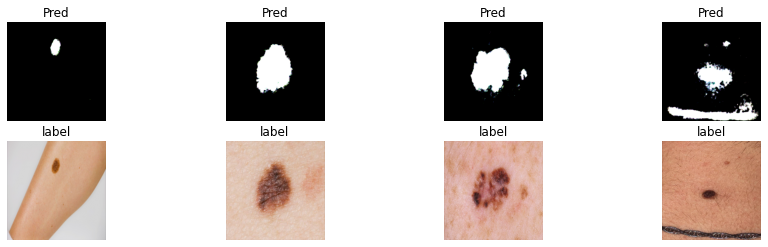

In [54]:
images = predict(model=model)